In [1]:
import sys
sys.executable

'/home/ksmehrab/miniconda/envs/py310/bin/python'

## Step 1: Generate SAM proposals

In [23]:
# Import necessary libraries
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from hydra import initialize, compose
import hydra
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

In [8]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [11]:
"""
Set paths to the SAM2 checkpoint and config file
"""
sam2_checkpoint = "/home/ksmehrab/SAM2/sam2/checkpoints/sam2.1_hiera_large.pt"
config_dir = "./sam2.1"
model_cfg = "sam2.1_hiera_l.yaml"
# model_cfg = "./sam2.1/sam2.1_hiera_l.yaml"
hydra.core.global_hydra.GlobalHydra.instance().clear()

device='cuda'
with initialize(config_path=config_dir):
    cfg = compose(config_name=model_cfg)
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device).eval()

# predictor = SAM2ImagePredictor(sam2_model)

/tmp/ipykernel_1540166/1261130536.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=config_dir):


In [25]:
# --- make the generator (tune knobs below) ---
mask_generator = SAM2AutomaticMaskGenerator(
    sam2_model,
    points_per_side=64,              # grid density; increase for more proposals
    points_per_batch=128,            # speed vs VRAM
    pred_iou_thresh=0.75,            # drop low-quality masks earlier
    stability_score_thresh=0.85,     # stability filter
    box_nms_thresh=0.85,              # dedupe overlapping proposals
    crop_n_layers=1,                 # >0 enables multi-crop for more/cleaner masks
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0,          # >0 removes tiny regions/holes (needs OpenCV)
    output_mode="binary_mask",       # or "coco_rle" / "uncompressed_rle"
    multimask_output=True            # keep multiple candidates per point
)

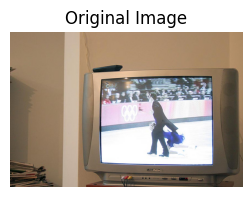

In [46]:
# Load the input image
image_path = "/data/Pascal_VOC_2012/VOCdevkit/VOC2012/JPEGImages/2008_002464.jpg"  # Update with the path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [47]:
# --- generate proposals ---
with torch.inference_mode(), torch.autocast(device, dtype=torch.bfloat16 if device=="cuda" else torch.float32):
    proposals = mask_generator.generate(image)

print(f"#proposals: {len(proposals)}")

#proposals: 65


In [60]:
# sort by quality and keep top-K
proposals = sorted(proposals, key=lambda x: (x["predicted_iou"], x["stability_score"]), reverse=True)
top = proposals[:10]

In [ ]:
import pickle
with open("SAMProposals/example1.pkl", "wb") as f:
    pickle.dump(top, f)

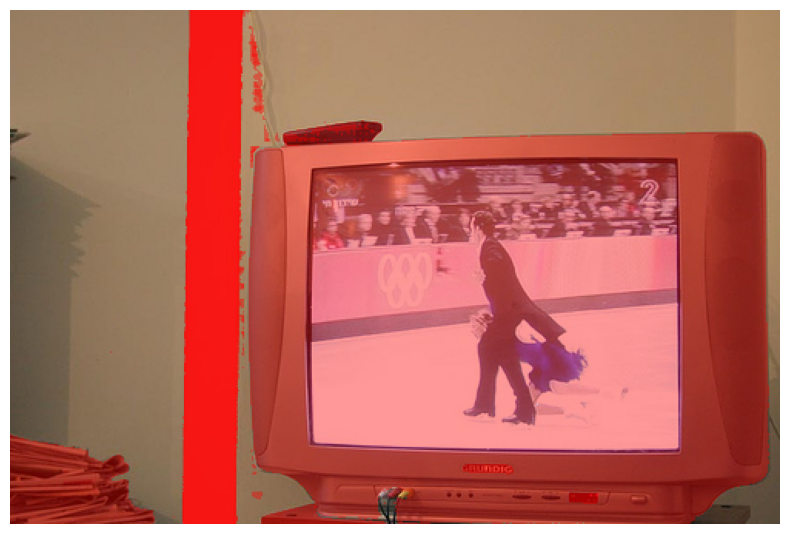

In [63]:
overlay = image.copy()
for p in top:
    m = p["segmentation"].astype(bool)
    overlay[m] = (0.6*overlay[m] + 0.4*np.array([255, 0, 0])).astype(np.uint8)

plt.figure(figsize=(8,6)); plt.imshow(overlay); plt.axis("off"); plt.tight_layout(); plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Optional for COCO-RLE proposals
try:
    from pycocotools import mask as cocomask
except Exception:
    cocomask = None

def _to_bool_mask(seg, H, W):
    """Return a (H,W) bool mask from ndarray or COCO-RLE dict."""
    if isinstance(seg, np.ndarray):
        m = seg.squeeze()
        if m.ndim != 2:
            raise ValueError(f"Unexpected mask shape {seg.shape}; expected (H,W) or (H,W,1).")
        return m.astype(bool)
    if isinstance(seg, dict):
        if cocomask is None:
            raise RuntimeError("pycocotools not installed but proposals use COCO RLE.")
        rle = seg
        if isinstance(rle.get("counts"), list):  # uncompressed -> compress
            rle = cocomask.frPyObjects(rle, H, W)
        m = cocomask.decode(rle)
        if m.ndim == 3:
            m = m[..., 0]
        return m.astype(bool)
    raise ValueError(f"Unknown segmentation format: {type(seg)}")

def show_topk_proposals_grid(
    image_rgb,
    proposals,
    k=100,
    grid=(10, 10),
    alpha=0.80,                       # blend factor for color overlay
    dim_alpha=0.25,                   # how much to dim background
    color_mode="random",              # "random" or "fixed"
    highlight_color=(255, 0, 0),      # used if color_mode=="fixed"
    draw_bbox=True,
    sort_key=lambda p: (p.get("predicted_iou", 0.0), p.get("stability_score", 0.0)),
    rng_seed=0,                        # for deterministic random colors
    save_path=None
):
    """
    Visualize up to K proposals; each subplot overlays ONLY that region with a color.

    Args:
        image_rgb: HxWx3 uint8 RGB image.
        proposals: list of SAM2AutomaticMaskGenerator dicts.
        k: number of proposals to show.
        grid: (rows, cols).
        alpha: overlay strength for the color (0..1).
        dim_alpha: background dim factor (0..1).
        color_mode: "random" for per-proposal colors, "fixed" for one color.
        highlight_color: (R,G,B) if color_mode == "fixed".
        draw_bbox: outline predicted bbox if available.
        sort_key: how to rank proposals before taking top-k.
        rng_seed: seed for color randomness.
    """
    H, W = image_rgb.shape[:2]
    rows, cols = grid
    k = min(k, len(proposals), rows * cols)

    props = sorted(proposals, key=sort_key, reverse=True)[:k]

    # Precompute dimmed background
    dimmed = (image_rgb.astype(np.float32) * (1.0 - dim_alpha)).astype(np.uint8)

    # RNG for reproducible colors
    rng = np.random.default_rng(rng_seed)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes.flat[i]
        ax.axis("off")

        if i >= k:
            ax.imshow(np.zeros_like(image_rgb))
            continue

        p = props[i]
        mask = _to_bool_mask(p["segmentation"], H, W)      # (H,W) bool
        m3 = mask[..., None]                                # (H,W,1) for broadcasting

        # Choose color
        if color_mode == "fixed":
            color = np.array(highlight_color, dtype=np.uint8)
        else:
            color = rng.integers(0, 256, size=3, dtype=np.uint8)

        # Start from dimmed background
        canvas = dimmed.copy()

        # Blend fixed color onto masked region
        # result = alpha*color + (1-alpha)*canvas (only where mask==True)
        blended = (alpha * color + (1.0 - alpha) * canvas).astype(np.uint8)
        canvas = np.where(m3, blended, canvas)

        ax.imshow(canvas)

        if draw_bbox and "bbox" in p:
            x, y, w, h = p["bbox"]
            rect = plt.Rectangle((x, y), w, h, fill=False, linewidth=1.0)
            ax.add_patch(rect)

        piou = p.get("predicted_iou", None)
        stab = p.get("stability_score", None)
        title = f"#{i+1}"
        if (piou is not None) and (stab is not None):
            title += f"  IoU:{piou:.2f}  Stab:{stab:.2f}"
        ax.set_title(title, fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=500)
    plt.show()


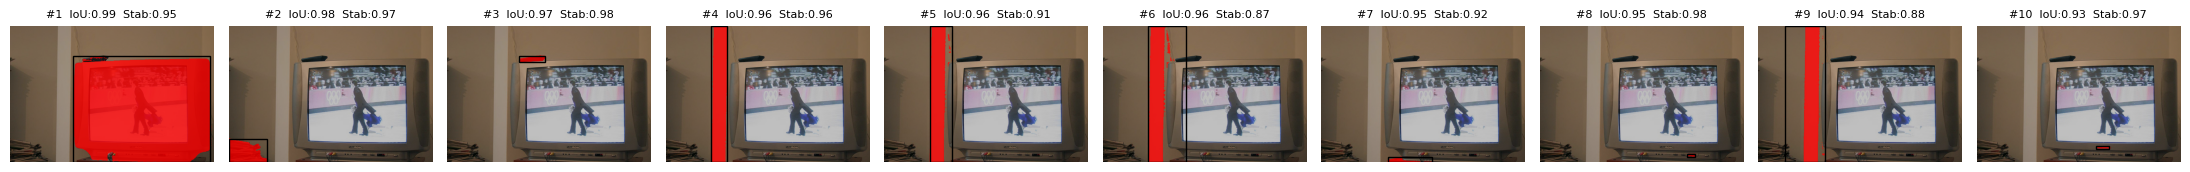

In [54]:
# Fixed red overlay
show_topk_proposals_grid(image, proposals, k=10, grid=(1,10),
                         color_mode="fixed", highlight_color=(255,0,0), alpha=0.8,
                         save_path="SAMProposalExamples/example1.png")


## Step 2: VLM description of the proposed regions

In [1]:
# load saved proposals
import pickle
with open("SAMProposals/example1.pkl", "rb") as f:
    top = pickle.load(f)

In [2]:
from PIL import Image 
import matplotlib.pyplot as plt

In [3]:
from vllm import LLM, SamplingParams

/home/ksmehrab/miniconda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 09-16 13:07:19 [__init__.py:216] Automatically detected platform cuda.


In [4]:
# Qwen2-VL
def run_qwen2_vl(question: str, modality: str):

    model_name = "Qwen/Qwen2-VL-7B-Instruct"

    llm = LLM(
        model=model_name,
        max_model_len=4096,
        max_num_seqs=5,
        # Note - mm_processor_kwargs can also be passed to generate/chat calls
        mm_processor_kwargs={
            "min_pixels": 28 * 28,
            "max_pixels": 1280 * 28 * 28,
        },
    )

    if modality == "image":
        placeholder = "<|image_pad|>"
    elif modality == "video":
        placeholder = "<|video_pad|>"

    prompt = ("<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
              f"<|im_start|>user\n<|vision_start|>{placeholder}<|vision_end|>\n<|vision_start|>{placeholder}<|vision_end|>\n"
              f"{question}<|im_end|>\n"
              "<|im_start|>assistant\n")
    stop_token_ids = None
    
    return llm, prompt, stop_token_ids

In [ ]:
llm, prompt, stop_token_ids = run_qwen2_vl(
    question="You are given the full image (first) and a cropped region (second). Describe ONLY the cropped region in rich detail—appearance, parts, color/texture, visible text, and state.",
    modality="image"
)   

In [ ]:
# load qwen2.5-VL-7B-Instruct
# model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
# llm = LLM(model=model_name, trust_remote_code=True)

In [ ]:
# tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# messages = [
#     {"role": "user", "content":
#      "<image>\n"}You are given the full image (first) and a cropped region (second). Describe ONLY the cropped region in rich detail—appearance, parts, color/texture, visible text, and state.
# ]
# prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [6]:
image_path = "/data/Pascal_VOC_2012/VOCdevkit/VOC2012/JPEGImages/2008_002464.jpg"
full_img = Image.open(image_path).convert("RGB")
# text_prompt = (
#     "You are given the full image (first) and a cropped region (second). "
#     "Describe ONLY the cropped region in rich detail—appearance, parts, color/texture, visible text, and state."
# )

vllm_prompts = []
for p in top:
    bbox = tuple(p['bbox'])
    crop  = full_img.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
    vllm_prompts.append({
        "prompt": prompt,
        "multi_modal_data": {"image": [full_img, crop]}
    })

In [8]:
sampling_params = SamplingParams(
    temperature=0.2, 
    top_p=0.9, 
    max_tokens=256
)

In [9]:
outs = llm.generate(vllm_prompts, sampling_params)

Processed prompts: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, est. speed input: 443.72 toks/s, output: 184.48 toks/s]


In [11]:
generated_texts = []
for o in outs:
    generated_text = o.outputs[0].text
    generated_texts.append(generated_text)

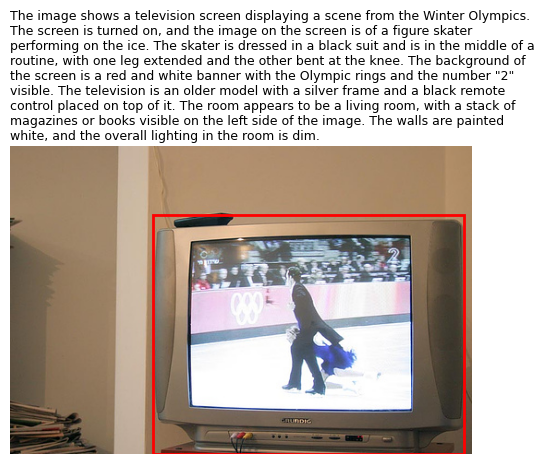

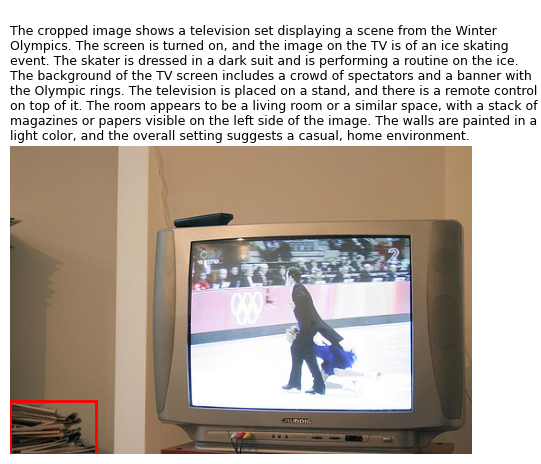

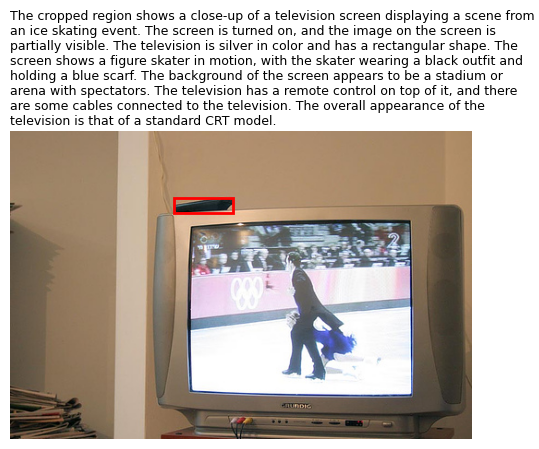

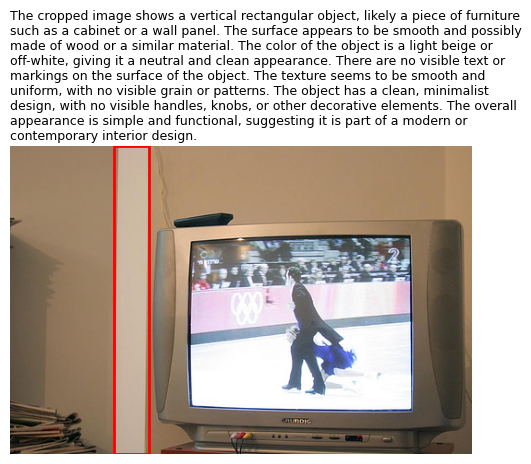

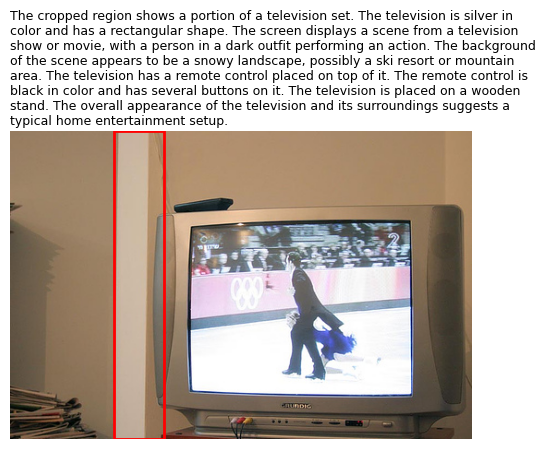

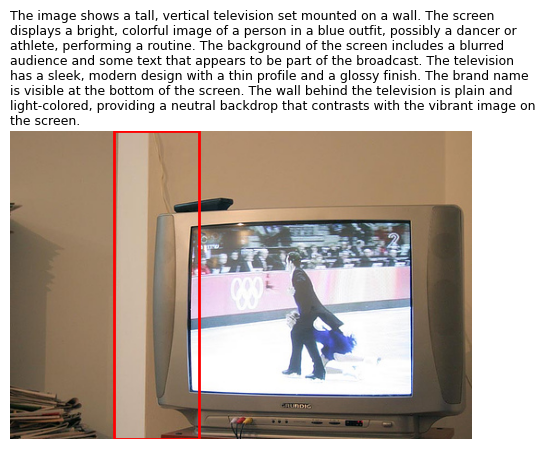

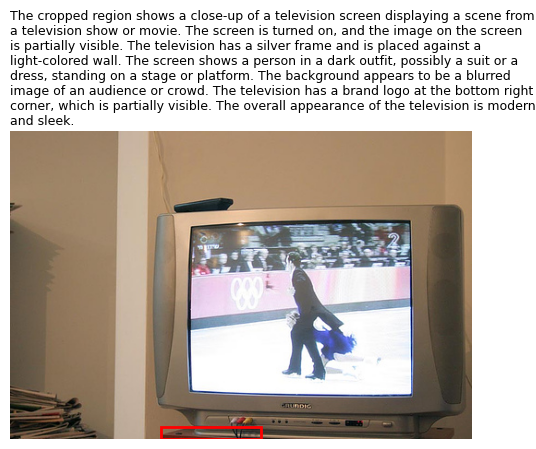

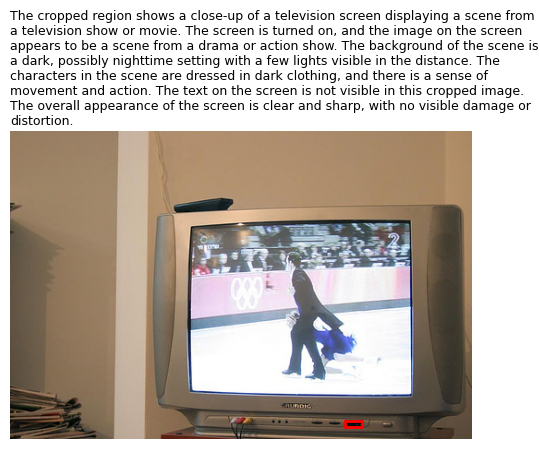

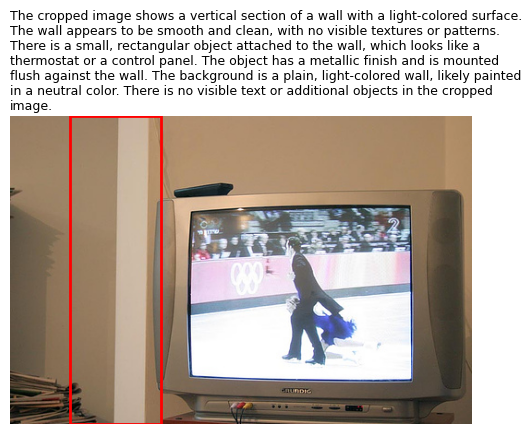

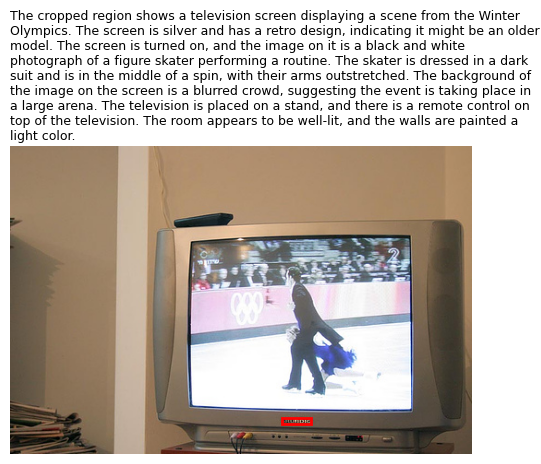

In [12]:
for p, txt in zip(top, generated_texts):
    bbox = tuple(p['bbox'])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(full_img)
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.axis("off")
    plt.title(txt, fontsize=9, loc='left', wrap=True)
    plt.show()

## Step 3: Generate description of the object that we are looking for 

In [20]:
placeholder = "<|image_pad|>"
class_name = "TV Remote Controller"
question = f"Given the image, describe the {class_name} in rich detail—appearance, parts, color/texture, visible text, and state. Only describe the {class_name}. Only describe what is visible in the image."
prompt_for_class = ("<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
    f"<|im_start|>user\n<|vision_start|>{placeholder}<|vision_end|>\n"
    f"{question}<|im_end|>\n"
    "<|im_start|>assistant\n")

In [21]:
prompt = {
    "prompt": prompt_for_class,
    "multi_modal_data": {"image": full_img}
}

In [22]:
out = llm.generate(prompt, sampling_params)

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 139.63 toks/s, output: 46.71 toks/s]


In [28]:
class_description = out[0].outputs[0].text

In [29]:
from IPython.display import display, HTML
display(HTML(f"<pre style='white-space: pre-wrap; word-break: break-word;'>{class_description}</pre>"))

## Step 4: Perform some sort of text score matching

In [58]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch

# bi-encoder for embeddings (fast)
embed_model_name = "BAAI/bge-base-en-v1.5"  
embed_model = SentenceTransformer(embed_model_name, device="cuda" if torch.cuda.is_available() else "cpu")
embed_model.max_seq_length = 512  

# encode 
q_emb = embed_model.encode([class_description], normalize_embeddings=True)
c_emb = embed_model.encode(generated_texts, normalize_embeddings=True)

# cosine similarity
scores = (q_emb @ c_emb.T).flatten()  # since normalized, dot = cosine

# top-k 
k = 9
topk_idx = torch.topk(torch.tensor(scores), k).indices.tolist()
topk = [(generated_texts[i], float(scores[i])) for i in topk_idx]


In [59]:
req_top = [top[i] for i in topk_idx]
req_gen_texts = [generated_texts[i] for i in topk_idx]

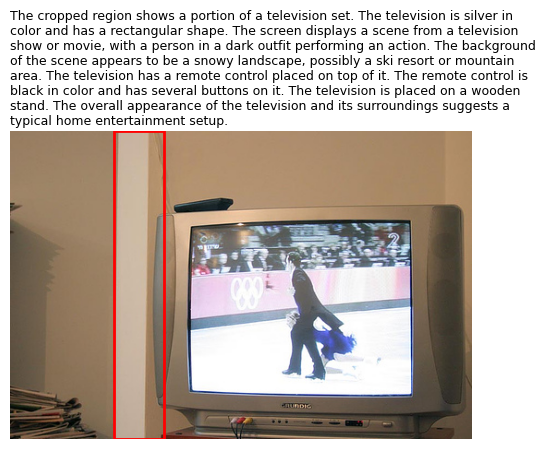

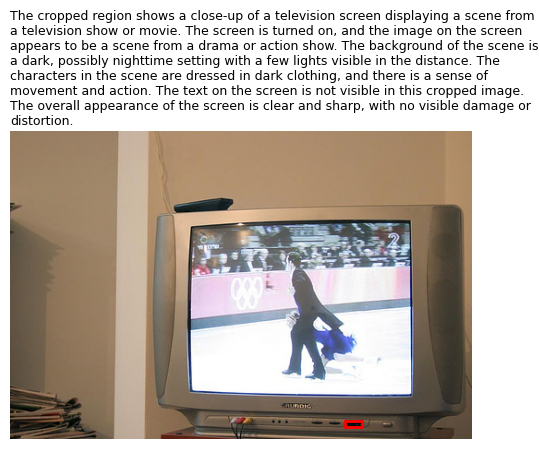

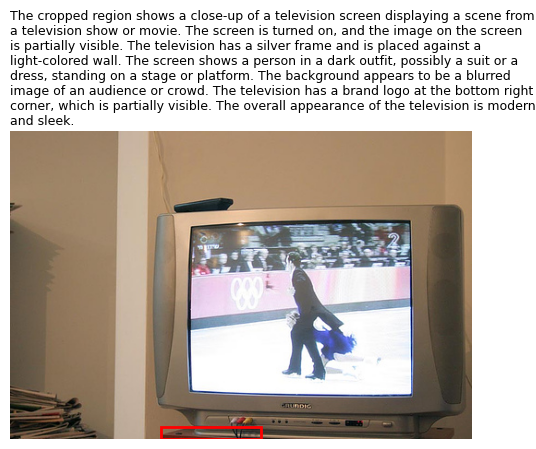

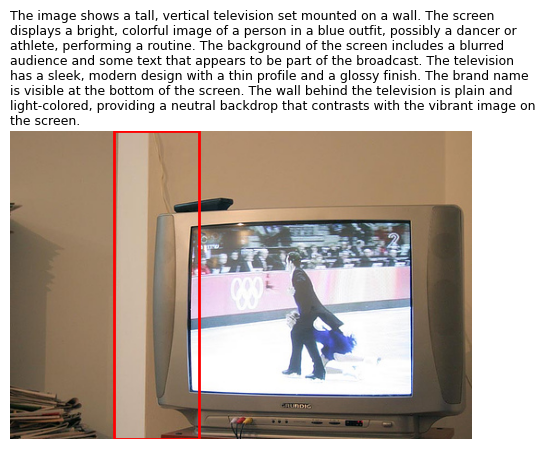

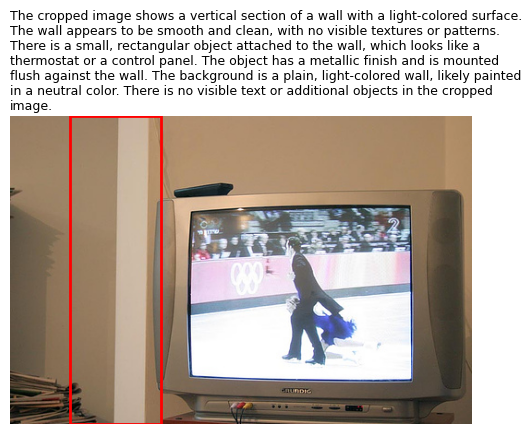

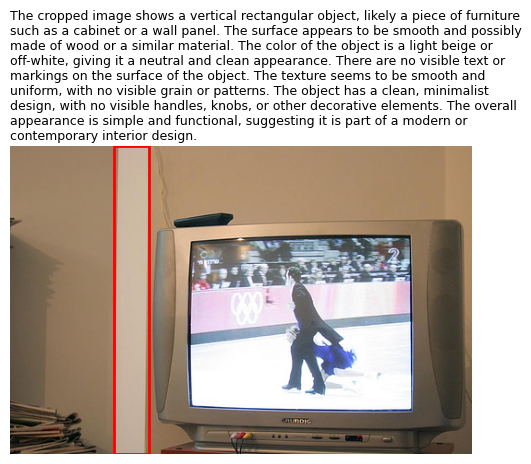

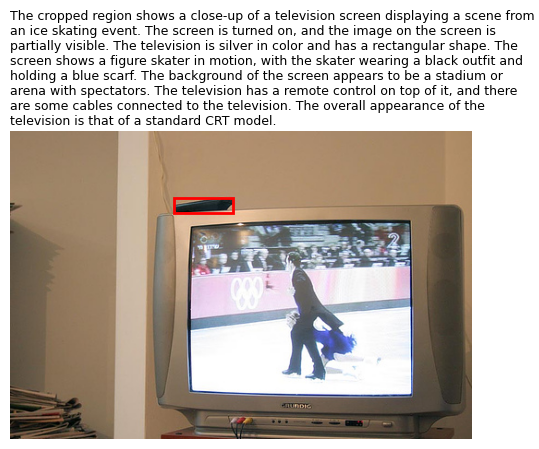

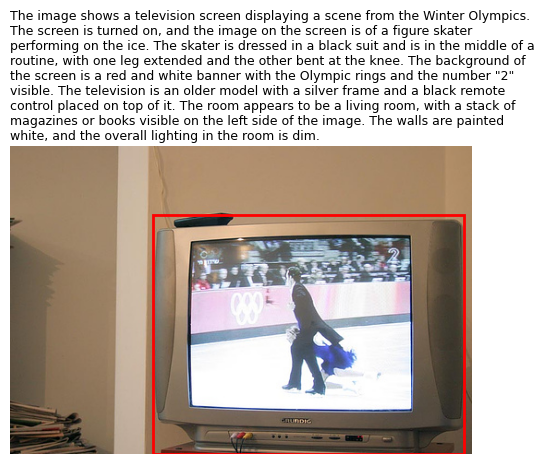

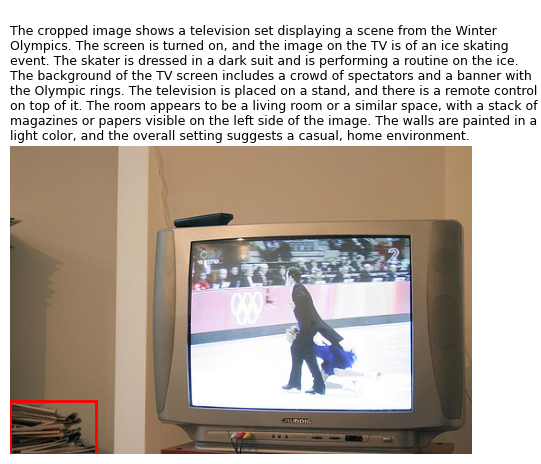

In [60]:
for p, txt in zip(req_top, req_gen_texts):
    bbox = tuple(p['bbox'])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(full_img)
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.axis("off")
    plt.title(txt, fontsize=9, loc='left', wrap=True)
    plt.show()